In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import requests
import tarfile
import shutil
import scipy.io
import pandas as pd
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time




Code to move files and count number of files in a folder

In [ ]:

test_dir = '/content/drive/MyDrive/MIDL/car_data/test'
train_dir = '/content/drive/MyDrive/MIDL/car_data/train'
# Get a list of subdirectories in the test directory
subdirectories = [subdir for subdir in os.listdir(test_dir) if os.path.isdir(os.path.join(train_dir, subdir))]
count = 0
# Iterate over each subdirectory
for subdir in subdirectories:
    test_subdir = os.path.join(test_dir, subdir)
    train_subdir = os.path.join(train_dir, subdir)

    # Create the corresponding subdirectory in the train directory if it doesn't exist


    # Get a list of files in the test subdirectory
    files = os.listdir(test_subdir)
    print(len(files))
    print(files)
    count=count+1

    # Move the first two files to the train subdirectory
    for i in range(2):
        file = files[i]
        src = os.path.join(test_subdir, file)
        dst = os.path.join(train_subdir, file)


print('Files moved successfully.')
print(count)

Pre-Processing Step 1: Using Bounding Box to crop training images.


In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import cv2



train_dir = os.listdir('/content/drive/MyDrive/car_data/car_data/test')
train_csv = pd.read_csv("/content/drive/MyDrive/MIDL/Cars_Dataset/Stanford/anno_test.csv", header = None)
data_labels = np.array(pd.read_csv('/content/drive/MyDrive/MIDL/Cars_Dataset/Stanford/names.csv',\
                                   header = None))

idx = np.unique(np.array([label[0][0:-5] for label in data_labels]), return_index = True)[1]
labels_wo_year = np.array([np.array([label[0][0:-5] for label in data_labels])[idx] for idx in sorted(idx)])



os.chdir('/content/drive/MyDrive/car_data/car_data/test')
for folder in train_dir:
    folder_read = folder + '/*.jpg'


    # reading from each class directory folder
    filelist = glob.glob(folder_read)

    all_files = [fname [-9:] for fname in filelist]


    sc_data = np.array([cv2.imread(fname) for fname in filelist])

    for i in range(len(sc_data)):
        file_dir = folder + '/' + all_files[i]
        annot = train_csv.loc[train_csv[0] == all_files[i]]
        if not annot.empty:
          #cropping images using bounding boxes
          x1 = annot.iloc[0, 1]
          y1 = annot.iloc[0, 2]
          x2 = annot.iloc[0, 3]
          y2 = annot.iloc[0, 4]
          cv2.imwrite(file_dir, sc_data[i][y1:y2, x1:x2])




<ipython-input-53-835a7d92e92c>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sc_data = np.array([cv2.imread(fname) for fname in filelist])


Delete any empty folders in the dataset to avoid errors

In [ ]:
import os

def delete_empty_folders(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir in dirs:
            folder_path = os.path.join(root, dir)
            if len(os.listdir(folder_path))==0:  # Check if folder is empty
                print(folder_path)# Delete the empty folder

# Specify the directory path where you want to delete empty folders
directory_path = '/content/drive/MyDrive/MIDL/car_data/test'

# Call the function to delete empty folders
delete_empty_folders(directory_path)

Create Validation set from the Testing set with a 20/80 split

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Subset

def create_validation_set(test_dataset,validation_ratio):

# Calculate the number of samples for validation set
  num_samples = len(test_dataset)
  num_validation_samples = int(validation_ratio * num_samples)

  # Create indices for splitting the dataset
  indices = list(range(num_samples))
  validation_indices = indices[:num_validation_samples]
  test_indices = indices[num_validation_samples:]

  # Create the validation dataset
  validation_dataset = Subset(test_dataset, validation_indices)

  # Create the test dataset
  test_dataset = Subset(test_dataset, test_indices)

  # Create data loaders for validation and test datasets
  validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
  return validation_loader,test_loader,validation_dataset

In [ ]:
test_loader, validation_loader,validation_dataset=create_validation_set(dataset2,0.2)

Apply Data Augmentation and Image normalization and prepare the train and test loaders

In [ ]:
dataset_dir = "/content/drive/MyDrive/MIDL/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

In [ ]:
print(len(dataset))

8190


Visualize the train, test, and validation batches

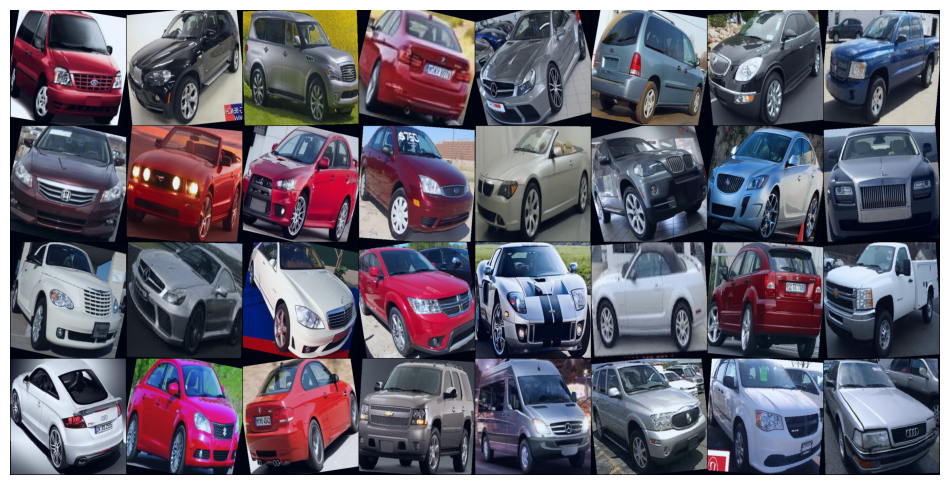

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of images from the trainloader
for images, labels in trainloader:
    break

# Create a grid of images
grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)

# Convert tensor to numpy array
grid = grid.numpy().transpose(1, 2, 0)

# Display the images
plt.figure(figsize=(12, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

Downloading RESNET 50

In [ ]:

# Set the directory to which the model weights should be saved
torch.hub.set_dir('/content/drive/MyDrive/MIDL/Models/')

# Download ResNet-50
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.fc
num_classes = len(dataset.classes)
num_test= len(dataset2.classes)
print(num_test)
print(num_classes)

196
196


Double-check numbers of classses in the train and test directories

In [ ]:
import os
import shutil

test_dir = '/content/drive/MyDrive/MIDL/car_data/test'
train_dir = '/content/drive/MyDrive/MIDL/car_data/train'

# Get the list of classes in the testing dataset
test_classes = os.listdir(train_dir)


# Iterate over the training dataset and remove classes not in the testing dataset
for class_name in os.listdir(test_dir):
    if class_name not in test_classes:
        class_dir = os.path.join(test_dir, class_name)
        print(1)

# Optional: Update the list of classes after filtering
updated_classes = os.listdir(test_dir)
print("Updated number of classes:", len(updated_classes))

['Hyundai Santa Fe SUV 2012', 'Dodge Durango SUV 2012', 'GMC Canyon Extended Cab 2012', 'Dodge Dakota Crew Cab 2010', 'Buick Rainier SUV 2007', 'Dodge Ram Pickup 3500 Quad Cab 2009', 'Chevrolet Silverado 1500 Extended Cab 2012', 'Hyundai Tucson SUV 2012', 'Jeep Compass SUV 2012', 'Bentley Continental Supersports Conv. Convertible 2012', 'Land Rover Range Rover SUV 2012', 'Ford Mustang Convertible 2007', 'Ford Edge SUV 2012', 'Chevrolet Silverado 2500HD Regular Cab 2012', 'Audi TT RS Coupe 2012', 'Bentley Continental GT Coupe 2012', 'Audi 100 Wagon 1994', 'Mercedes-Benz Sprinter Van 2012', 'Dodge Challenger SRT8 2011', 'Dodge Charger SRT-8 2009', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Volkswagen Beetle Hatchback 2012', 'Rolls-Royce Ghost Sedan 2012', 'Honda Odyssey Minivan 2007', 'Jaguar XK XKR 2012', 'Ford F-150 Regular Cab 2007', 'BMW X5 SUV 2007', 'Chrysler 300 SRT-8 2010', 'Acura TSX Sedan 2012', 'Aston Martin V8 Vantage Convertible 2012', 'FIAT 500 Convertible 2012', '

End of Pre-processing and start of model architecture and training

In [ ]:
for param in model.parameters():
    param.required_grad = False

First Experiment Fully connected layer

In [ ]:

classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1024, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=512, out_features=196),
  nn.LogSoftmax(dim=1)
)

model.fc = classifier
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=196, bias=True)
  (7): LogSoftmax(dim=1)
)

Function for training model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):

    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)

        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
        torch.save(model_ft.state_dict(), '/content/drive/MyDrive/MIDL/Models/model.pt')
    print('Finished Training')
    return model, losses, accuracies, test_accuracies



Function to test model

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc



Downloading Resnet 34 and changing the fully connected layer

In [ ]:
torch.hub.set_dir('/content/drive/MyDrive/MIDL/Models/')
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 196)

model_ft = model_ft.to(device)
print(model_ft.fc)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /content/drive/MyDrive/MIDL/Models/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.7MB/s]


Linear(in_features=2048, out_features=196, bias=True)


Following 3 lines are to configure my gpu device

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 256 s, loss: 4.0557, acc: 15.2832
Accuracy of the network on the test images: 33 %
Epoch 2, duration: 260 s, loss: 1.4751, acc: 62.2559
Accuracy of the network on the test images: 51 %
Epoch 3, duration: 261 s, loss: 0.7042, acc: 81.6772
Accuracy of the network on the test images: 61 %
Epoch 4, duration: 261 s, loss: 0.4034, acc: 89.5020
Accuracy of the network on the test images: 62 %
Epoch 5, duration: 261 s, loss: 0.2572, acc: 93.5303
Accuracy of the network on the test images: 68 %
Epoch 6, duration: 260 s, loss: 0.1955, acc: 94.9707
Accuracy of the network on the test images: 71 %
Epoch 7, duration: 260 s, loss: 0.1405, acc: 96.1914
Accuracy of the network on the test images: 74 %
Epoch 8, duration: 261 s, loss: 0.1027, acc: 97.3633
Accuracy of the network on the test images: 74 %
Epoch 9, duration: 261 s, loss: 0.0752, acc: 98.2422
Accuracy of the network on the test images: 74 %
Epoch 10, duration: 261 s, loss: 0.0431, acc: 99.0967
Accuracy of the network on t

Code to load a random image and obtain a prediction from the model.

In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
import PIL.Image as Imag
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open("/content/drive/MyDrive/MIDL/Cars_Dataset/Stanford/car_data/car_data/test/Cadillac CTS-V Sedan 2012/00556.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

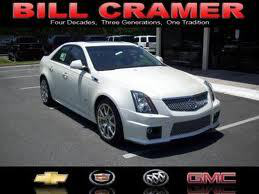

Cadillac CTS-V Sedan 2012 confidence:  7.518689155578613


In [ ]:
display(Image.open("/content/drive/MyDrive/MIDL/Cars_Dataset/Stanford/car_data/car_data/test/Cadillac CTS-V Sedan 2012/00556.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

Code to test model on testing dataset

In [ ]:
model_ft.eval()
test_accuracy = eval_model(model_ft)
print(test_accuracy)